In [ ]:
Goal of This Step

You want to:

Understand which features affect default

Find patterns & risk signals

Decide which features are useful for modeling

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('../data/processed/credit_data_cleaned.csv')
df.head()

,clientid,income,age,loan,default,loan_log
0,1,66155.92510,59,8106.532131,0,9.000549
1,2,34415.15397,48,6564.745018,0,8.789621
2,3,57317.17006,63,8020.953296,0,8.989937
3,4,42709.53420,46,6103.642260,0,8.716805
4,5,66952.68885,19,8770.099235,1,9.079217


### Target Variable Analysis

In [ ]:
df['default'].value_counts(normalize=True)*100
# class is imbalanced with few defaulters
# 14% defaulters , 86% non-defaulters

default
0    85.85
1    14.15
Name: proportion, dtype: float64

### Numerical features vs default
checking how numbers like loan, income, age behave for people who defaulted vs those who dint default

In [10]:
df.groupby('default')['loan_log'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,1717.0,7.910997,1.057942,0.866104,7.443472,8.14555,8.658493,9.530033
1,283.0,8.823234,0.384010,7.822498,8.602654,8.87940,9.109181,9.501352


In [11]:
df.groupby("default")["income"].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,1717.0,45318.317216,14318.556075,20014.48947,32657.26868,45783.15475,57914.731070,69995.68558
1,283.0,45412.188607,14398.556175,20063.09958,33438.77004,45980.33434,57544.413625,69958.70554


In [12]:
df.groupby("default")["age"].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,1717.0,43.322073,12.673479,18.0,34.0,44.0,54.0,64.0
1,283.0,26.406360,4.795191,18.0,22.0,26.0,30.0,35.0


### Distribution plots

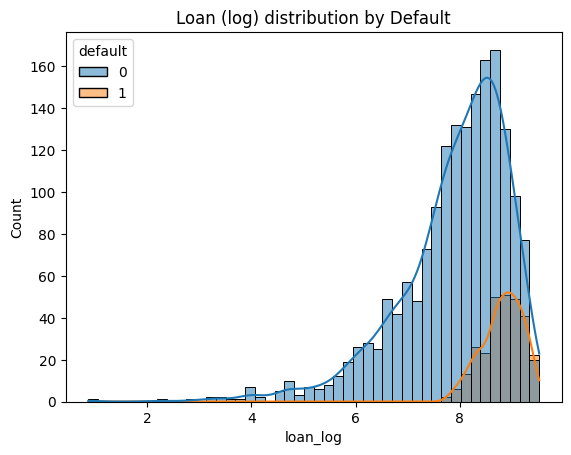

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df, x="loan_log", hue="default", kde=True)
plt.title("Loan (log) distribution by Default")
plt.show()

# insights:
# people who default usually took higher loans
# overlap exsists: some non-defaulters also took high loans
# hence, loan amount alone cannot predict default
# but is a strong contributing factor

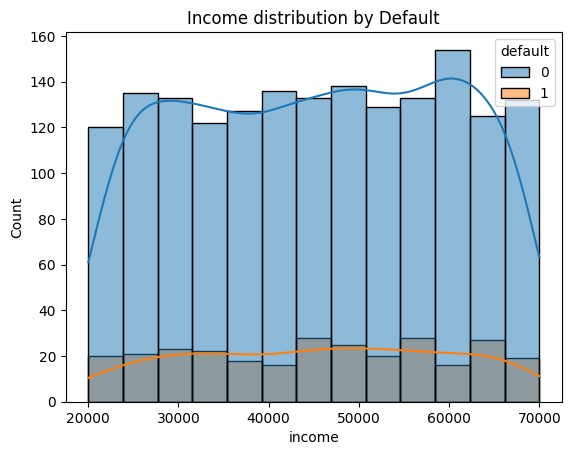

In [ ]:
sns.histplot(df, x="income", hue="default", kde=True)
plt.title("Income distribution by Default")
plt.show()

# insights:
# People with both low and high income are able to repay loans
# High income does NOT completely eliminate default risk
# the blue and orange distributions overlap heavily
# This suggests that income alone is not a strong predictor of default risk

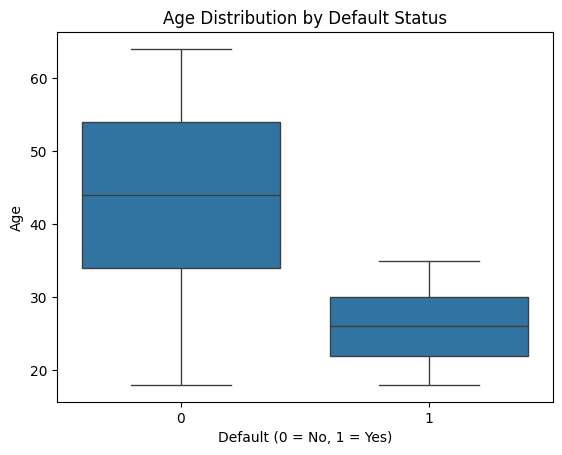

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='default', y='age', data=df)
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Age')
plt.title('Age Distribution by Default Status')
plt.show()


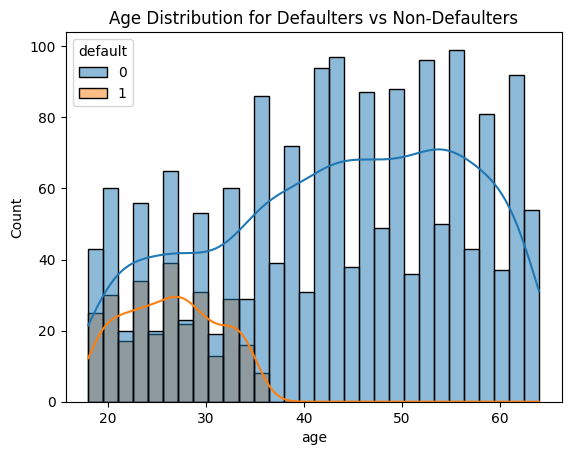

In [17]:
sns.histplot(data=df, x='age', hue='default', bins=30, kde=True)
plt.title('Age Distribution for Defaulters vs Non-Defaulters')
plt.show()


Exploratory analysis shows that loan amount is strongly associated with default risk, with defaulters tending to take larger loans. Age also shows a clear pattern, where younger customers exhibit higher default rates compared to older customers. Income shows significant overlap between defaulters and non-defaulters, indicating a weaker individual effect. These insights suggest loan amount and age are important predictors of default.

In [ ]:
# mean comparison - simple stats
df.groupby('default')['loan_log'].mean()

# If defaulters have higher mean → risk signal

default
0    7.910997
1    8.823234
Name: loan_log, dtype: float64

In [ ]:
# statistical test - t-test
from scipy.stats import ttest_ind

defaulters = df[df["default"] == 1]["loan_log"]
non_defaulters = df[df["default"] == 0]["loan_log"]

ttest_ind(defaulters, non_defaulters, equal_var=False)

# Welch’s t-test compares mean log loan amounts of defaulters vs non-defaulters.
# The very large t-value (26.6) and extremely small p-value (~0)
# show a highly significant difference between the two groups.
# Hence, loan amount (log scale) is strongly associated with default status.


TtestResult(statistic=26.636150003928577, pvalue=7.458664371218187e-122, df=1136.5765138119862)

In [ ]:
from scipy.stats import ttest_ind

defaulters = df[df["default"] == 1]["age"]
non_defaulters = df[df["default"] == 0]["age"]

ttest_ind(defaulters, non_defaulters, equal_var=False)

# This is the result of a Welch’s t-test comparing the means of two groups.

# The t-value = −40.46 is very large in size, which means the difference between the two group averages is huge.

# The negative sign (−) shows that the first group’s mean is smaller than the second group’s mean.

# The p-value ≈ 0 means this difference is not due to chance.
# Thus, age is strongly associated with default status.

TtestResult(statistic=-40.45992745334614, pvalue=5.194527731584434e-218, df=1071.6952087594457)

In [24]:
# VIF (Variance Inflation Factor) checks multicollinearity

# It tells how much a feature is correlated with other features
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df[["loan_log", "income", "age"]]

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) 
              for i in range(X.shape[1])]

vif


,Feature,VIF
0,loan_log,20.202822
1,income,12.128238
2,age,9.119958


In [ ]:
# VIF results show strong multicollinearity.
# loan_log and income have very high VIF (>10), indicating redundancy.
# Age is borderline but acceptable.
# Consider dropping income or using regularization.


In [25]:
# VIF (Variance Inflation Factor) checks multicollinearity

# It tells how much a feature is correlated with other features
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df[["loan_log", "age"]]

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) 
              for i in range(X.shape[1])]

vif


,Feature,VIF
0,loan_log,9.119906
1,age,9.119906


In [ ]:
# After removing income, VIF values drop below 10.
# Multicollinearity is now at an acceptable level.
# loan_log and age can be safely used together.


1. Important features
- Log Loan amount
- Age